In [358]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

% LaTeX macros...
$\newcommand{\N}{\mathbb{N}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\P}{\mathcal{P}}$
$\newcommand{\U}{\mathcal{U}}$
$\newcommand{\dd}{\, \mathrm{d}}$
$\newcommand{\dt}[1]{\overset{\circ}{#1}}$
$\newcommand{\intset}[2]{\{#1, ..., #2\}}$

Notations:
- $\dt{x}$ is the derivative in time of x;
- if $x$ is a column vector, $x^T$ is the corresponding row vector;
- $A^T$ is the transpose of $A$. 

# Problem presentation and parameterization

Let's start with a very simple Linear Quadratic Control problem.

We study the movement of cart assimilated to a mechanical point of mass $m > 0$ that moves along an axis. Its position is denoted by $x \in \Omega = \R$. The cart starts from position $x_0 \in \Omega_0 = [-1, 0]$ and velocity $0$, and we want to bring the cart to position $0$ and keep it there as long as possible over a horizon $T$, with minimal control $u \in \R$. The control is here interpreted as a direct control of the velocity of the cart (and not of its acceleration).

In what follows we take $m=1$.

In [359]:
T = 1  # Time horizon for the control problem

## Formulation as a Continuous control problem

We denote by:
- $x: [0, T] \to \Omega$ the trajectory of the cart, that is its position at every time $t$;
- $u: [0, T] \to U$, where $U=\R$, the control overt time $t$. In what follows, we'll look for $u \in \U$ where $\U = L^1([0, T], U)$.

The dynamic of the system is given by the Cauchy problem:
$$
    \begin{cases}
        \dt{x}(t) = u(t) & \forall t \in [0, T],\\
        x(0) = x_0,
    \end{cases}
$$
where $x_0 \in [-1, 0]$.

Our choice of $\U$ ensures by Cauchy-Lipschitz theorem that this problem has a unique solution $x_u \in AC([0, T], \R)$.

We then want to minimize:
$$
    \min_{u \in \U} J(u),
$$
where
$$
    J(u) = \int_0^T \big( \lambda x(T)^2 + u(t)^2 \big) dt
$$
where $\lambda > 0$

In [360]:
LAMBDA = 10  # Null trajectory factor

This problem can be rewritten as a Linear Control Regulator (LQR):
$$
    \min_{u \in \U} J(u),
$$
where
$$
    J(u) = \int_0^T (x_u^T Q x_u + u^TRu) dt + x_u(T)^T D x_u(T)
$$
and
$$
    \begin{cases}
        \dt{x_u}(t) = Ax(t) + Bu(t) & \forall t \in [0, T],\\
        x(0) = x_0,
    \end{cases}
$$
where $A=0$, $B=1$, $Q=\lambda$, $R=1$ and $D=0$

## Remarks on the problem

This problem has several differences from the one tackled by Carlos Esteve in hiw work:
 - the problem is continuous both in time and space, so we will have to discretize it in time and (depending on the Q-learning algorithm we're using) in space;
 - the problem has a finite time-horizon T, and the optimal control at a given position in space depends on the remaining time before the horizon is reached: this makes the problem slightly more difficult and time should be part of the state of the system;
 - however, the reward can easily be defined at intermediary states, and not only at the final stage, which makes the learning process much easier (we can _almost_ just minimizing the current running cost!).

It also has some differences from RL for the control of Burgers:
 - We are not exactly trying to reach a target state _at_ a final time T here, but _over_ a time period $[0, T]$. The reason for this choice is that the optimal control would be a cosntant if we were trying to reach the target at time T, which is too simple.
 - The system is not governed by a PDE, but by a (simple) ODE. With a PDE, we might need another discretization in space to apply e.g. finite element methods (and we could make this discretization coincide with the one used to define Q as an array, see the implementation of the simple Q-learning method below). Our integrator would be more complicated than the one presented here.

# Utils

In [361]:
def plot_trajectory(predicted_x=None, gt_x=None, recenter=False):
    """
    Plots the ground truth trajectory vs the predicted trajectory on a (t, x) plot.
    
    Parameters
    ----------
    predicted_x: None | np.array of floats
        Regularly spaced samples of the predicted trajectory. If None, this trajectory is not plotted.
    gt_x: None | np.array of floats
        Regularly spaced samples of the ground truth trajectory. If None, this trajectory is not plotted.
        
    Return
    ------
    None
    """
    plt.figure()
    if predicted_x is not None:
        t_prediction = np.linspace(0, T, predicted_x.shape[0])
        plt.plot(t_prediction, predicted_x, label="Prediction", color="tab:blue")
    if gt_x is not None:
        t_gt = np.linspace(0, T, gt_x.shape[0])
        plt.plot(t_gt, gt_x, label="Ground truth", color="tab:orange")
    if recenter:
        plt.ylim([-1, 0])
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("Trajectories")
    plt.legend()
    plt.grid()
    plt.show()

In [362]:
def plot_control(predicted_u=None, gt_u=None):
    """
    Plots the ground truth control vs the predicted control on a (t, u) plot.
    
    Parameters
    ----------
    predicted_u: None | np.array of floats
        Regularly spaced samples of the predicted control. If None, this control is not plotted.
    gt_u: None | np.array of floats
        Regularly spaced samples of the ground truth control. If None, this control is not plotted.
        
    Return
    ------
    None
    """
    plt.figure()
    if predicted_u is not None:
        t_prediction = np.linspace(0, T, predicted_u.shape[0])
        plt.scatter(t_prediction, predicted_u, label="Prediction", color="tab:blue", marker="x")
    if gt_u is not None:
        t_gt = np.linspace(0, T, gt_u.shape[0])
        plt.plot(t_gt, gt_u, label="Ground truth", color="tab:orange")
    plt.xlabel("t")
    plt.ylabel("u")
    plt.title("Controls")
    plt.legend()
    plt.grid()
    plt.show()

In [363]:
def transform_interval(a, b, c, d, x):
    """
    Affine transformation that maps an interval [a, b] to an interval [c, d].
    
    Parameters
    ----------
    a: int
        Lower bound of the departure interval.
    b: int
        Upper bound of the departure interval.
    c: int
        Lower bound of the departure interval.
    d: int
        Upper bound of the departure interval.
    x: float
        The point to map from [a, b] to [c, d].
        
    Return
    ------
    The point of [c, d] that is the image of x by the affine transformation.
    """
    return (d-c)/(b-a)*x + (c*b-d*a)/(b-a)

In [364]:
def plot_loss_history(loss_history, evaluate_every=1, function_name="loss"):
    """
    Plots the loss history over episodes.
    
    Parameters
    ----------
    loss_history: np.array of floats
        The history of the loss.
    evaluate_every: int
        Number of training episodes ran between each evaluation. This is used to determine the correct scaling from the x axis.
        
    Return
    ------
    None
    """
    plt.figure()
    plt.plot(np.arange(0, evaluate_every*loss_history.shape[0], evaluate_every), loss_history)
    plt.title(f"History of the {function_name} during training")
    plt.xlabel("Episodes")
    plt.ylabel("Cost")
    plt.grid()
    plt.show()

# Continuous control implementation

Using the adjoint state $p$, we can get an analytical solution for the continuous control problem. Indeed, the control is optimal if and only if:
$$
    u(t) = -R^{-1}Bp(t) = -p(t) \qquad \forall t \in [0, T],
$$
where
$$
\begin{cases}
    \dt{p}(t) = -Ap(t) - Qx(t) = -\lambda x(t) & \forall t \in [0, T],\\
    p(T) = 0
\end{cases}
$$
Hence:
$$
\begin{cases}
    \dt{x} = u = p,\\
    \dt{p} = -\lambda x.
\end{cases}
$$
That is, for $X^T=(x\ p)$,
$$
    \dt{X} = Z X
$$
where
$$
    Z =\begin{pmatrix}
        0 & -1\\
        -\lambda & 0
    \end{pmatrix}.
$$
We thus know that:
$$
    X(t) = \begin{pmatrix} x_0 \\ p(0) \end{pmatrix} e^{tZ}.
$$
We compute by hand:
$$
    e^Z =\begin{pmatrix}
        \cosh(\sqrt{\lambda}) & -\frac{1}{\sqrt{\lambda}}\sinh(\sqrt{\lambda})\\
        -\sqrt{\lambda}\sinh(\sqrt{\lambda}) & \cosh(\sqrt{\lambda})
    \end{pmatrix}.
$$
and deduce:
$$
\begin{cases}
    x(t) = x_0\cosh(\sqrt{\lambda}t) - \frac{p(0)}{\sqrt{\lambda}}\sinh(\sqrt{\lambda}t),\\
    p(t) = -\sqrt{\lambda}x_0\sinh(\sqrt{\lambda}t) + p(0)\cosh(\sqrt{\lambda}t).
\end{cases}
$$
Lastly, using the fact that $p(T)=0$, we compute:
$$
\boxed{
\begin{cases}
    x(t) = \frac{x_0}{\cosh(\sqrt{\lambda}T)} \cosh\big(\sqrt{\lambda}(T-t)\big)\\
    u(t) = - p(t) = -\frac{\sqrt{\lambda}x_0}{\cosh(\sqrt{\lambda}T)}\sinh\big(\sqrt{\lambda}(T-t)\big)
\end{cases} \qquad \forall t \in [0, T].
}
$$

In [365]:
def ground_truth(x0, t):
    """
    Analytical expressions of the trajectory and the control for the continuous control problem.
    
    Parameters
    ----------
    x0: float in [-1, 0]
        Initial condition.
        
    Return
    ------
    A tuple of np.arrays (gt_x, gt_u) both of shape (res).
    """
    sqrtl = np.sqrt(LAMBDA)
    cosht = np.cosh(sqrtl*T)
    return (x0/cosht)*np.cosh(sqrtl*(T-t)), -(sqrtl*x0/cosht*np.sinh(sqrtl*(T-t)))

In [366]:
def ground_truth_sample(x0, res=10000):
    """
    Sample of the trajectory and control solution to the continuous control problem.
    
    Parameters
    ----------
    x0: float in [-1, 0]
        Initial condition.
    res: int
        Number of points to sample.
        
    Return
    ------
    A tuple of np.arrays (gt_x, gt_u) both of shape (res).
    """
    t = np.linspace(0, T, res)
    return ground_truth(x0, t)

In [367]:
def cost(x, u):
    """
    Compute an approximation of the cost function evaluated in a given trajectory-control pair (x, u), using trapezoidal rule.
    
    Parameters
    ----------
    x: np.array of floats
        The trajectory.
    u: np.array of floats
        The control.
            
    Return
    ------
    Approximation of the cost.
    """
    return LAMBDA*np.trapz(x**2, dx=T/x.shape[0]) + np.trapz(u**2, dx=T/u.shape[0])

## Visualization of the solution

In [368]:
x0 = -1
gt_x, gt_u = ground_truth_sample(x0)
print("Position at final time:", gt_x[-1])

Position at final time: -0.08450702270392474


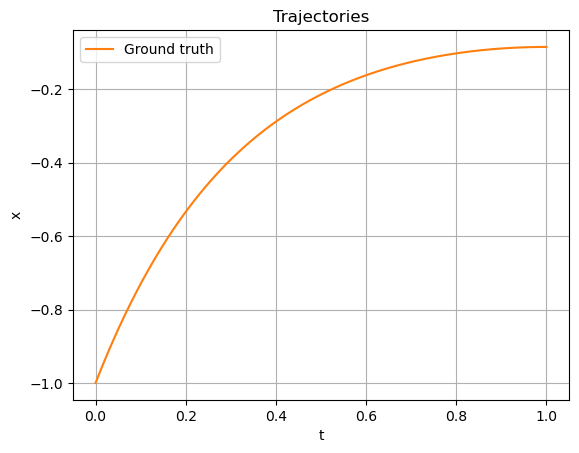

In [369]:
plot_trajectory(gt_x=gt_x, recenter=False)

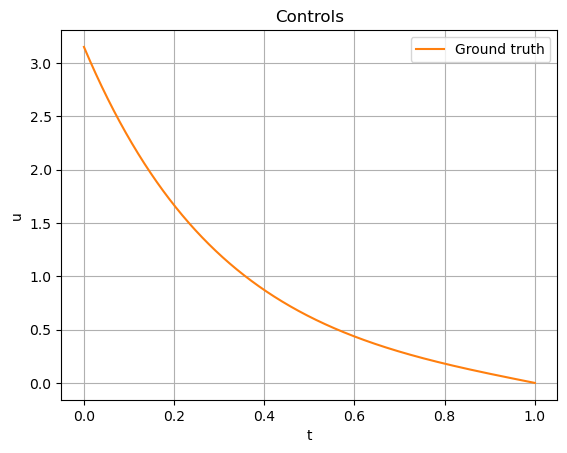

In [370]:
plot_control(gt_u=gt_u)

In [371]:
# Approximation of the optimal cost
cost(*ground_truth_sample(x0))

3.150650833590185

# Reinforcement Learning implementation

To make the problem solvable by RL using Q-learning methods (discrete and deep), we need to discretize it in time. Let $N \in \N^*$ be the discretization resolution and $\Delta t = \frac{T}{N} = \frac{1}{N}$ the time step. Let $\forall n \in \intset{0}{N}, \ t_n = n \Delta t, \ u_n = u(t_n)$ and $x_n = x(t_n)$.

With this discretization, we now _choose_ to restrict the search of a control $u$ in a subset $\U_{\Delta t} \subset \U$, namely:
$$
    \U_{\Delta t} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N}, u_n \in U \right\}.
$$
This means that we can only hope to get a _suboptimal_ solution for the continuous control problem.

Moreover, we observe that for any $u \in \U_{\Delta t}$ and any $n \in \intset{1}{N}$:
$$
    x_{n+1} = x_n + \int_{t_n}^{t_{n+1}} \dt{x}(t) \dd t = x_n + \int_{t_n}^{t_{n+1}} u_n \dd t = x_n + \Delta t\,u_n,
$$
which encourages us to choose the following simulator that we will call every $\Delta t$ time step to compute the trajectory on points $x_n, \ n \in \intset{0}{N}$:
$$
\P: \begin{align}
    & \Omega \times U \to \Omega \\
    & (x, u) \mapsto x +\Delta t\, u.
\end{align}
$$
Note that this simulator is equivalent to using an _Euler explicit_ integration scheme but it computes the _exact_ value of $x_{n+1}$. This is because in our dynamics, $A=0$ and because we chose a convenient shape for $u$. For harder problems, we might want to use a numerical integration method which won't give the exact trajectory.

In this framing, the cost function _rewrites_:
$$
    J(u) = \lambda \int_0^T x(t)^2 \dd t + \Delta t \sum_{n=0}^{N-1} u_n^2
$$
Here we could use an exact value for the term on the left because we can integrate $x$ easily, but in many cases this expression would be hard to get. So, we'll try to minimize an approximation $J_D$ of $J$:
$$
    J_{\Delta t}(u) = \lambda \Delta t \sum_{n=0}^{N} x_n(t)^2 + \Delta t \sum_{n=0}^{N-1} u_n^2
$$
Here again, because of this we cannot expect to find an optimal solution for the continuous control problem, and it could be interesting to see what happens when $\Delta t \to 0$.

To sum up, the problem becomes:
$$
    \min_{u \in \U_{\Delta t}} \lambda \Delta t \sum_{n=0}^{N} x_n(t)^2 + \Delta t \sum_{n=0}^{N-1} u_n^2
$$

In [372]:
N = 20  # Number of time steps
DT = 1/N  # Time step

## Discrete Q-learning

### Discretization

In a first RL approach, let's use the $Q$-learning algorithm with an $\varepsilon$-policy, implementing $Q$ as a matrix such that $Q_{s, a}$ is an approximation of the $Q$ function in state $s$ and action $a$.

However, this implementation requires further discretizing the problem, both in state and action spaces.
Therefore, we arbitrarily restrain $U$ to $\tilde{U} = [U_l, U_r]$ (with $U_r \in \mathbb{Z}^-$ and $U_l \in \N$) and $\U$ to $\tilde{\U} = L^1\big( [0, T],  \tilde{U} \big)$. We also restrain $\Omega$ to $\tilde{\Omega} = [-\Omega_l, \Omega_r] = [-1 + U_l\,T, U_r\,T]$ which is a natural choice because it is the union of the sets $E(x_0, T) = \{x_1 \in \R | \exists u \in \tilde{\U}, \ x_u(T) = x_1 \} $ of reachable positions from $x_0$ and $T$, for $x_0 \in [-1, 0]$.

Let's introduce $N_\Omega$ and $N_U$ the discretization resolutions for $\tilde{\Omega}$ and $\tilde{U}$, and $\Delta x = \frac{1}{N_{\Omega}}$ and $\Delta u = \frac{1}{N_U}$. For consistency, if we want the minimal gap between 2 states to coincide with the minimal possible step taken by the system, we should choose $N_\Omega$ such that $\Delta x = \Delta u\,\Delta t$, that is $N_\Omega = \frac{N_U}{\Delta t}$.

We now look for $u$ in
$$
    \tilde{\U}_{\Delta t, \Delta u} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N}, u_n \in \tilde{U}_{\Delta u} \right\},
$$
where
$$
    \tilde{U}_{\Delta u} = \{U_l, U_l + \Delta u, ..., U_r\}
$$
(so $|\tilde{U}_{\Delta u}| = (U_r - U_l)N_U + 1$).
Note that this will further increase the suboptimality of the solution we can expect to find.

Furthermore, for a correctly truncated $x_0$, with our choice of $\tilde{\U}_{\Delta t, \Delta u}$, the $x_n, \ n \in \intset{0}{N}$, will be confined in:
$$
    \tilde{\Omega}_{\Delta x} = \{ \Omega_l, \Omega_l + \Delta u\,\Delta t, ..., \Omega_r \}
$$
(so $|\tilde{\Omega}_{\Delta x}| = (\Omega_r - \Omega_l)N_\Omega + 1$), which is consistent with our choice of $\Delta x$.

The minimization problem is now:
$$
    \min_{(u_n)_{n\in \{0, ..., N-1\}} \in (U_{\Delta u})^N} \lambda \Delta t \sum_{n=0}^{N} x_n(t)^2 + \Delta t \sum_{n=0}^{N-1} u_n^2
$$

We are not done yet, because in practice $x$ and $u$ need to be integers if we want to interprete them as indices for $Q_{x, u}$ easily. The states and controls manipulated by $Q$ and the policy will live in:
$$
    \tilde{\Omega}_{\Delta x}^{RL} = \{ 0, \Delta x, ..., (\Omega_r - \Omega_l) N_\Omega \Delta x \}
$$
and
$$
    \tilde{U}_{\Delta u}^{RL} = \{ 0, \Delta u, ..., (U_r - U_l) N_U \Delta u \}
$$
respectively. We define functions to easily switch from one representation to another:
- $\phi_{u \to u^{Rl}}$ to go from $\tilde{U}_{\Delta u}$ to $\tilde{U}_{\Delta u}^{RL}$;
- $\phi_{x \to x^{RL}}$ to go from $\tilde{\Omega}_{\Delta x}$ to $\tilde{\Omega}_{\Delta x}^{RL}$

and their inverses $\phi_{u^{Rl} \to u}$ and $\phi_{x^{RL} \to x}$

In [373]:
# Discretization parameters
Ul = -1; Ur = 4  # Bounds between which we look for u
OMEGAl = -1 + Ul*T; OMEGAr = Ur*T  # Bounds between which lives x
N_U = 5  # Resolution of the discretization on u
Du = 1/N_U  # Disctretization step on u
N_OMEGA = int(N_U/DT)  #  Resolution of the discretization on x
Dx = 1/N_OMEGA  # Disctretization step on x
u_to_u_RL = lambda u: int(transform_interval(Ul, Ur, 0, (Ur-Ul)*N_U, u))  # This is to convert a control to an index for the np.array Q
u_RL_to_u = lambda u: transform_interval(0, (Ur-Ul)*N_U, Ul, Ur, u)  # Inverse of the previous 
x_to_x_RL = lambda x: int(transform_interval(OMEGAl, OMEGAr, 0, (OMEGAr-OMEGAl)*N_OMEGA, x))  # This is to convert a state to an index for the np.array Q
x_RL_to_x = lambda x: transform_interval(0, (OMEGAr-OMEGAl)*N_OMEGA, OMEGAl, OMEGAr, x)  # Inverse of the previous 

# Q-learning algorithm parameters
LEARNING_RATE = 0.2  # Default learning rate
EPSILON = 0.2  # Default epsilon for the u-epsilon policy
N_EPSISODES = 100  # Default number of episodes for training

### Formulation

We have the following formulation in RL:
- state space: $S = \{0, \Delta t, ..., T\} \times \tilde{\Omega}_{\Delta x}^{RL}$;
- a state is $s \in S$ and is the data of a time step and a position of the cart at this time step;
- action space $A = \tilde{U}_{\Delta u}^{RL} $;
- an action is $a \in A$ and is a representation of the control $u$ at a given instant;
- transition function: $f: S \times A \to S$ defined by $f(s, a) = \phi_{x \to x^{Rl}}\Big(\P\big(\phi_{x^{Rl} \to x}(s), \phi_{u^{Rl} \to u}(a)\big)\Big)$
- running reward function: $\forall n \in \intset{0}{N-1}, \ r_n(s, a) = -\Delta t (\lambda |\phi_{x^{Rl} \to x}(s)|^2 + |\phi_{u^{Rl} \to u}(a)|^2)$
- final reward function: $r_f(s) = -\Delta t\,\lambda |\phi_{x^{Rl} \to x}(s)|^2$

Note that we include time in the state because the optimal control has no reason to depend only on $x$ and not on $x_0$; in other words, for a given position of the system, an optimal agent might want to take a different action depending on the remaining integration time.

### Implementation

In [374]:
def  transition_function(sn, an):
    """
    Takes state and action (s_n, a_n) and return a new state s_{n+1}.
    
    Parameters
    ----------
    sn: int
        State at time t_n, represented as an index for Q.
    an: int
        State at time t_n, represented as an index for Q.
        
    Return
    ------
    The new state s_{n+1}.
    """
    return x_to_x_RL(x_RL_to_x(sn) + DT*u_RL_to_u(an))

In [381]:
def  running_reward(sn, an):
    """
    Takes state and action (s_n, a_n) and returns the associated running reward.
    
    Parameters
    ----------
    sn: int
        State at time t_n, represented as an index for Q.
    an: int
        State at time t_n, represented as an index for Q.
        
    Return
    ------
    Running reward r_n.
    """
    return -DT * (LAMBDA*x_RL_to_x(sn)**2 + u_RL_to_u(an)**2)

def  final_reward(sN):
    """
    Takes state and action (s_N) and returns the associated final reward.
    
    Parameters
    ----------
    sN: int
        State at time T, represented as an index for Q.
        
    Return
    ------
    Final reward r_f.
    """
    return -DT*LAMBDA*x_RL_to_x(sN)**2

def total_reward(s, a):
    """
    Takes trajectories of state and action (s, a) and returns the associated total reward.
    
    Parameters
    ----------
    sN: int
        State at time T, represented as an index for Q.
        
    Return
    ------
    Final reward r_f.
    """
    cumulative_running_reward = 0
    for sn, an in np.column_stack((s[:-1], a[:-1])):
        cumulative_running_reward += running_reward(sn, an)
    return cumulative_running_reward + final_reward(s[-1])

In [382]:
def piece_wise_cosntant_u_sample(u, res=10000):
    """
    Takes the sample of a control u and returns a new sample of different resolution, interpolating u as a piece-wise constant function.
    
    Parameters
    ----------
    u: np.array of float
        Sample of a control function u.
    res: int
        New resolution with which to sample u.
        
    Return
    ------
    New sample of piece-wise cosntant u.
    """
    new_u_indices = np.arange(res)
    return u[np.floor(u.shape[0]/res*new_u_indices).astype(int)]

def piece_wise_constant_u_cost(x, u, res=10000):
    """
    Compute an approximation of the cost function evaluated in a given trajectory-control pair (x, u) with u piece-wise constant, using trapezoidal rule. u is interpolated as a piece-wise constant function and sampled using resolution `res`.
    
    Parameters
    ----------
    x: np.array of floats
        The trajectory.
    u: np.array of floats
        The control, considered constant between samples.
    res: int
        New resolution with which to sample u.
            
    Return
    ------
    Approximation of the cost.
    """
    new_u = piece_wise_cosntant_u_sample(u, res=res)
    return cost(x, new_u)

In [383]:
def simulator(x0, policy):
    """
    Run a simulation of the system between times 0 and T.
    
    Parameters
    ----------
    x0: float in [0, 1]
        State at time 0.
    policy: function from S to A
        Function that given a state returns an action.
        
    Return
    ------
    The couple (x, u) where x is the resulting trajectory and u the control, which are 2 np.arrays of sizes (N+1) and (N).
    """
    x = np.zeros(N+1)
    u = np.zeros(N+1)
    x[0] = x0
    for n in range(N):
        s = x_to_x_RL(x[n])
        a = policy(n, s)
        u[n] = u_RL_to_u(a)
        x[n+1] = x_RL_to_x(transition_function(s, a))
    u[-1] = 0  # u is given a shape N+1 to have matching shapes for x and u, which makes comparing with ground truth easier.
    return (x,u)

In [384]:
@dataclass
class TrainingHistory:
    cost = np.array([])
    reward = np.array([])
    evaluate_every: int

        
class Agent:
    def __init__(self, lr = LEARNING_RATE, eps = EPSILON, evaluate_every=500):
        self.Q = -max(LAMBDA, 1) * np.random.rand(N, (OMEGAr - OMEGAl)*N_OMEGA+1, (Ur - Ul)*N_U+1)  # Initialize Q randomly in an order of magnitude of the running cost
        self.lr = lr
        self.eps = eps
        self.training_history = TrainingHistory(evaluate_every=evaluate_every)
        cost, reward = self.evaluate()
        self.training_history.cost = np.array([cost])
        self.training_history.reward = np.array([reward])
    
    def policy(self, n, s):
        return np.argmax(self.Q[n, s, :])
    
    def Q_learn(self, n_episodes = 100000):
        evaluate_every = self.training_history.evaluate_every
        average_cost_over_episodes = np.zeros(n_episodes//evaluate_every)
        average_reward_over_episodes = np.zeros(n_episodes//evaluate_every)
        for k in range(n_episodes):
            x0 = -np.random.random()
            s = x_to_x_RL(x0)
            for n in range(N):
                if np.random.random() < self.eps:
                    eps_policy = lambda n, s: np.random.randint((Ur - Ul)*N_U+1)
                else:
                    eps_policy = self.policy
                a = eps_policy(n, s)
                s_new = transition_function(s, a)
                r = running_reward(s, a)
                if n == N-1:
                    self.Q[n, s, a] = (1-self.lr)*self.Q[n, s, a] + self.lr*(r + final_reward(s_new))
                else:
                    self.Q[n, s, a] = (1-self.lr)*self.Q[n, s, a] + self.lr*(r + np.max(self.Q[n+1, s_new, :]))
                s = s_new
            if k % evaluate_every == 0:
                index = k//evaluate_every
                average_cost_over_episodes[index], average_reward_over_episodes[index] = self.evaluate()
        self.training_history.cost = np.append(self.training_history.cost, average_cost_over_episodes)
        self.training_history.reward = np.append(self.training_history.reward, average_reward_over_episodes)
    
    def evaluate(self, n_trials=100):
        """ NB: this evaluation method gives more weight to instances with an initial state further from the target. """
        cumulative_cost = 0
        cumulative_reward = 0
        for _ in range(n_trials):
            x0 = -np.random.random()
            s, a = simulator(x0, self.policy)
            cumulative_cost += piece_wise_constant_u_cost(s, a)
            cumulative_reward += total_reward(s, a)
        return cumulative_cost/n_trials, cumulative_reward/n_trials

### Test

#### Utilitary function

The next function will allow us to visualize Q and interprete it.

In [385]:
def plot_Q(Q, n, state_zoom=None, colorbar_limits=None):
    """
    Plots the heatmap of the weights of Q (represented as a matrix) at time n*\Delta_t.
    The x and y axes are scaled to represent the states and actions in \Omega and U, not \Omega^{RL} and U^{RL}.
    
    Parameters
    ----------
    Q: np.array of size (T, |OMEGA^RL|, |A|) with OMEGA^RL and A the spatial-state and action spaces
        The array representing the Q function.
    n: int
        The time step at which we represent Q.
    state_zoom: None | tuple(int, int)
        Interval of the state to show on the heatmap. If None, shows the entire state space.
    colorbar_limits: None | tuple(float, float)
        Limits for the colorbar: values of Q above these bounds will be truncated to the closest bound. If None, no limit is applied.
        
    Return
    ------
    None
    """
    Q = Q[n]
    state_zoom = state_zoom if state_zoom else (0, Q.shape[0]-1)
    colorbar_limits = colorbar_limits if colorbar_limits else (None, None)
    truncated_Q = Q[state_zoom[0]:state_zoom[1]+1, :]
    plt.figure()
    plt.imshow(truncated_Q, vmin=colorbar_limits[0], vmax=colorbar_limits[1])
    yticks = np.arange(0, truncated_Q.shape[0], truncated_Q.shape[0]//5)
    plt.yticks(ticks=yticks, labels=[f"{x:.2f}" for x in x_RL_to_x(np.arange(state_zoom[0], state_zoom[1]+1, truncated_Q.shape[0]//5))])
    xticks = np.array([0, u_to_u_RL(0), Q.shape[1]-1])
    plt.xticks(ticks=xticks, labels=[Ul, 0, Ur])
    plt.colorbar()
    plt.title(f"Q function at time step {n}")
    plt.xlabel("a")
    plt.ylabel("s")
    plt.show()

#### Agent creation

Let's create an agent.

In [529]:
agent = Agent()

Predictions before any training:

In [552]:
x0 = -1
gt_x, gt_u = ground_truth_sample(x0)

In [553]:
predicted_x, predicted_u = simulator(x0, agent.policy)

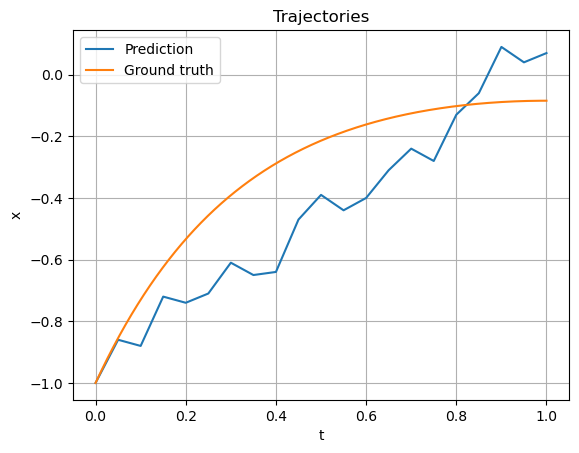

In [554]:
plot_trajectory(predicted_x=predicted_x, gt_x=gt_x)

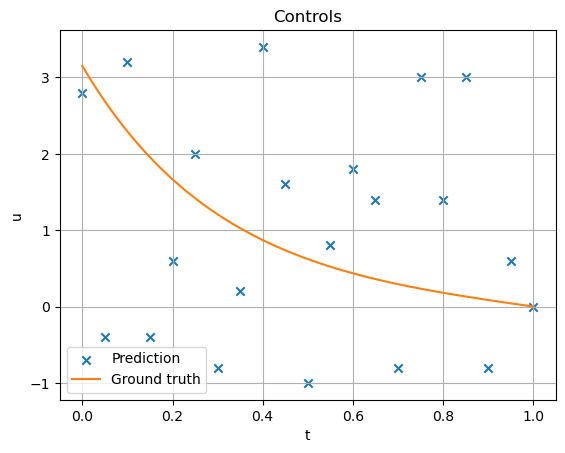

In [555]:
plot_control(predicted_u=predicted_u, gt_u=gt_u)

In [556]:
print("Cost for the predicted solution:", piece_wise_constant_u_cost(predicted_x, predicted_u))
print("Optimal cost:", cost(gt_x, gt_u))

Cost for the predicted solution: 5.895606285714285
Optimal cost: 3.150650833590185


$\to$ The predictions are not good, which is normal because Q is initialized randomly. In the following cell, we plot $Q$ at different time steps ($0$, $\frac{N}{2} T$ and $N-1$). Note that the $s$ dimension for $Q$ is very large because it needs to encompass all reachable states for our choice of $U_{\Delta u}^{RL}$, so we are here zooming on the part of interest, that is in the neighborhood of $[-1, 0]$.

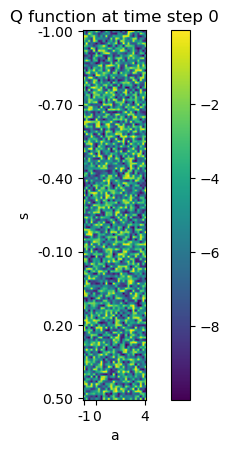

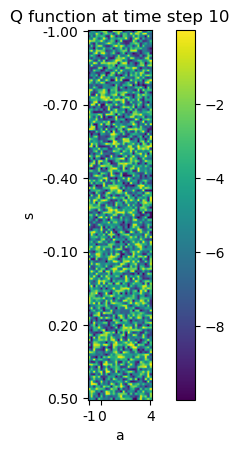

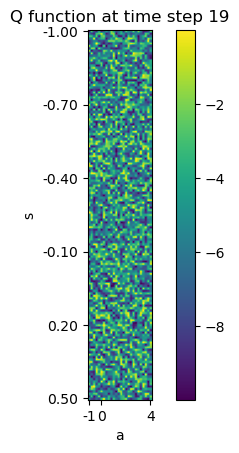

In [557]:
plot_Q(agent.Q, 0, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)))
plot_Q(agent.Q, N//2, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)))
plot_Q(agent.Q, N-1, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)))

### Training the agent

In [428]:
# With default parameters, this takes about 40s to run
agent.Q_learn()

Predictions after training:

#### Results

In [429]:
predicted_x, predicted_u = simulator(x0, agent.policy)

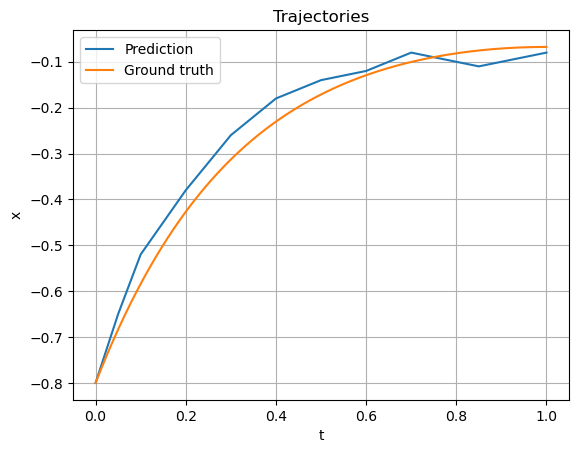

In [430]:
plot_trajectory(predicted_x=predicted_x, gt_x=gt_x)

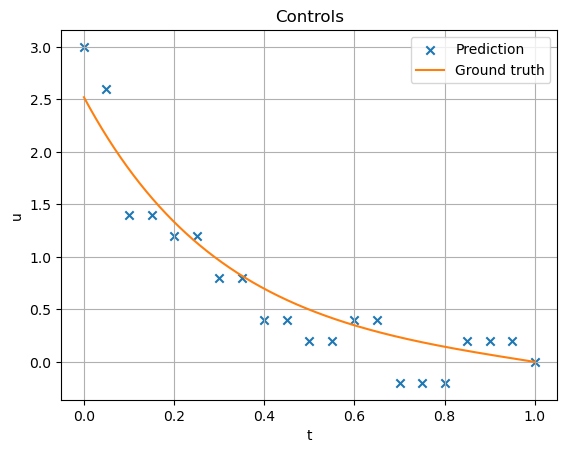

In [431]:
plot_control(predicted_u=predicted_u, gt_u=gt_u)

In [432]:
print("Cost for the predicted solution:", piece_wise_constant_u_cost(predicted_x, predicted_u))
print("Optimal cost:", cost(gt_x, gt_u))

Cost for the predicted solution: 2.0167962857142854
Optimal cost: 2.0164165334977184


Much better! We see that the agent has learnt to solve the problem: the cost has gotten closer to the optimal and the predicted curves are closer to the ground truth (although our discretization of $U$ and $\Omega$ remains rough). We see, however, that the agent tends to overshoot the target towards the end.

Let's visualize this learning by plotting the $Q$ function again (here we cut values below $-4$, $-3$ and $-2$ at the respective time steps $0$, $\frac{N}{2}$ and $T$ for better visualization) :

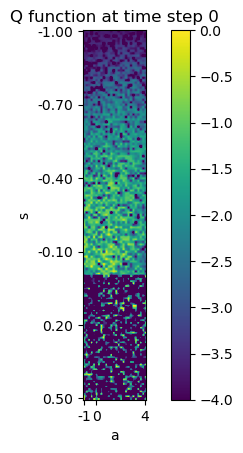

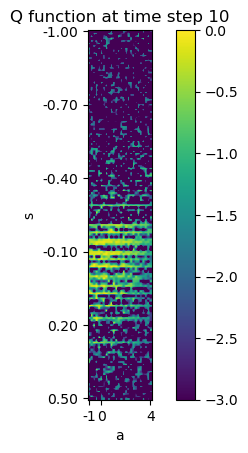

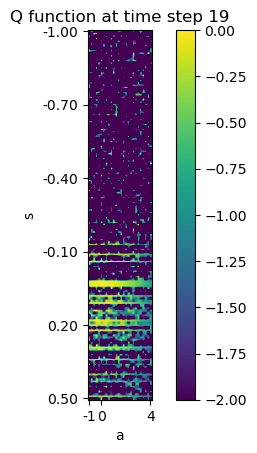

In [433]:
plot_Q(agent.Q, 0, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)), colorbar_limits=(-4, 0))
plot_Q(agent.Q, N//2, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)), colorbar_limits=(-3, 0))
plot_Q(agent.Q, N-1, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)), colorbar_limits=(-2, 0))

The $Q$ function is not random anymore! Let's make some observations.
 - At time $0$, the agent has fully explored states in $[-1, 0]$: this is normal, as it just corresponds to our initialization of $x_0$ durng training episodes.
 - Half-way through a simulation, the system is often already close to the target (above $-0.3$), so the agent has learnt over this portion of the state space.
 - The closer the system gets to $0$ and the more time has passed, the smaller the value of the $Q$-function becomes, which is natural.
 - At a given instant (notably towards the end), actions closer to $0$ tend to give better values of $Q$; otherwise the agent risk overshooting the target.

Finally, let's plot the evolution of the average cost as the agent has trained:

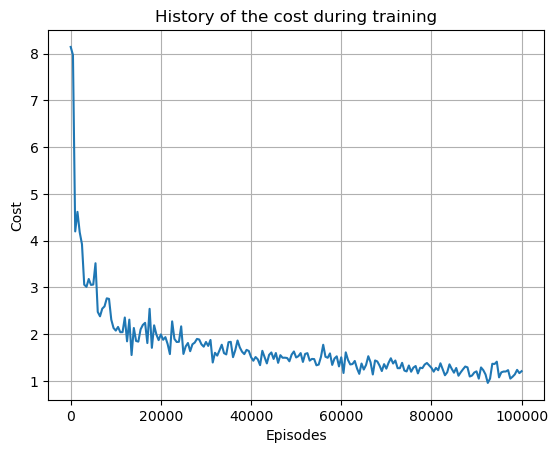

In [434]:
plot_loss_history(agent.training_history.cost, agent.training_history.evaluate_every, function_name="cost")

We observe that the average cost (for $x_0$ chosen uniformly in $[-1, 0]$) is decreasing and coverges to $\approx 1.1$.

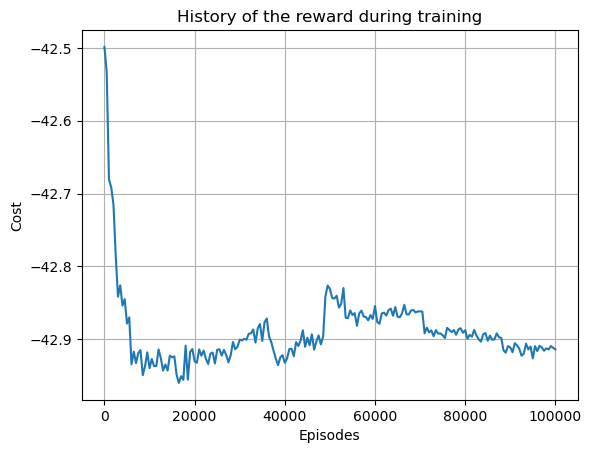

In [435]:
plot_loss_history(agent.training_history.reward, agent.training_history.evaluate_every, function_name="reward")

Conversely, the average reward (for $x_0$ chosen uniformly in $[-1, 0]$) increases and coverges to $\approx -42.75$. I don't explain the initial value of the average reward yet, however.

#### Twisting the parameters

Let's choose a bigger $\varepsilon$ for the $\varepsilon$-policy: the exploration phase should be more pronouced, and the agent should have some difficulty converging.

In [436]:
agent = Agent(eps=0.95)

In [437]:
agent.Q_learn()

In [438]:
x0 = -0.8
gt_x, gt_u = ground_truth_sample(x0)
predicted_x, predicted_u = simulator(x0, agent.policy)

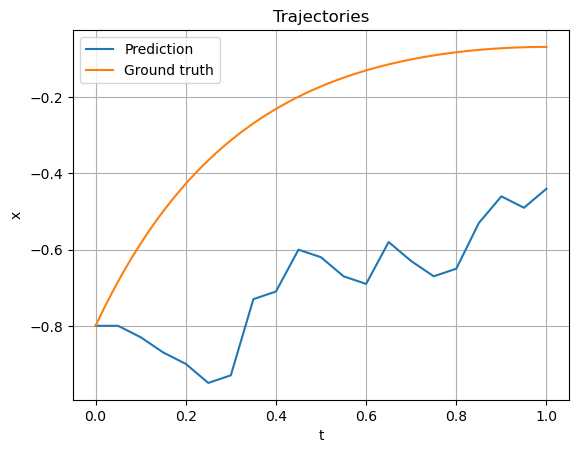

In [439]:
plot_trajectory(predicted_x=predicted_x, gt_x=gt_x)

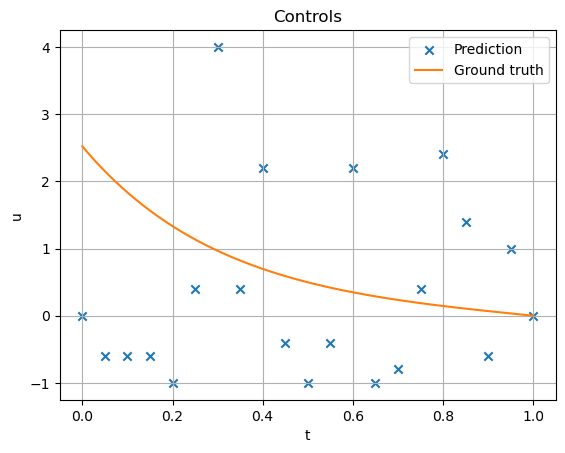

In [440]:
plot_control(predicted_u=predicted_u, gt_u=gt_u)

In [441]:
print("Cost for the predicted solution:", piece_wise_constant_u_cost(predicted_x, predicted_u))
print("Optimal cost:", cost(gt_x, gt_u))

Cost for the predicted solution: 6.738269523809524
Optimal cost: 2.0164165334977184


The solution is of the same order of magnitude as before, but slightly better.

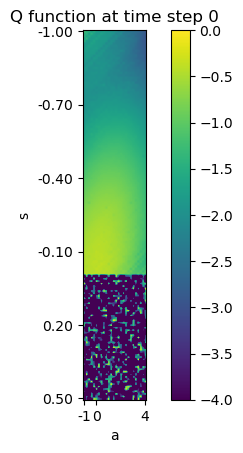

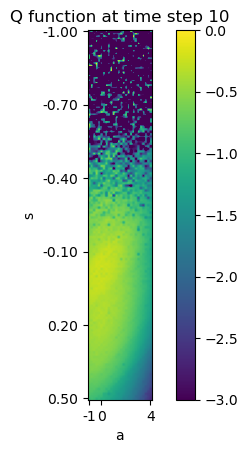

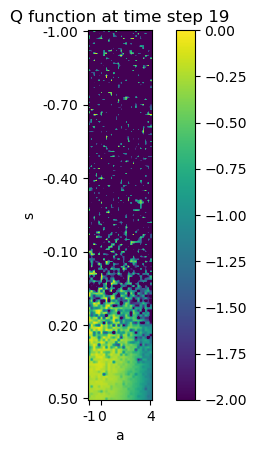

In [442]:
plot_Q(agent.Q, 0, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)), colorbar_limits=(-4, 0))
plot_Q(agent.Q, N//2, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)), colorbar_limits=(-3, 0))
plot_Q(agent.Q, N-1, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)), colorbar_limits=(-2, 0))

The Q function is smoother and more largely explored, because the random decisions taken by the agent during the training allows the system to go almost anywhere at any time! Despite this, we still find the coherence already observed with the previous choice of parameters.

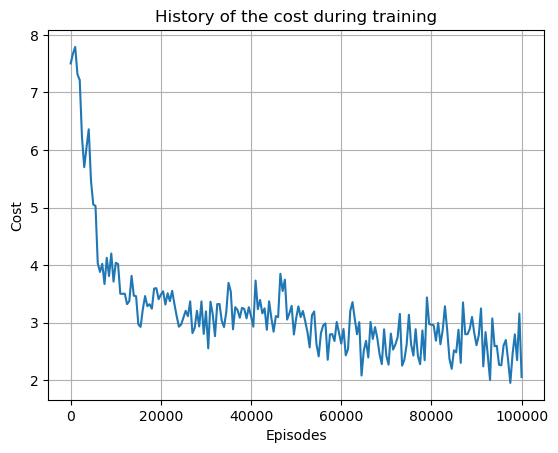

In [443]:
plot_loss_history(agent.training_history.cost, agent.training_history.evaluate_every, function_name="cost")

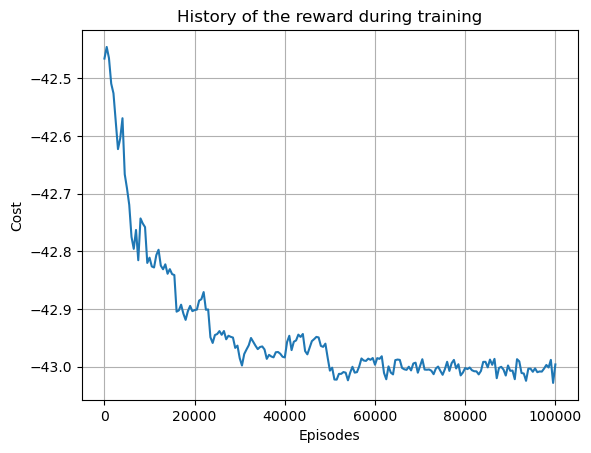

In [444]:
plot_loss_history(agent.training_history.reward, agent.training_history.evaluate_every, function_name="reward")

We observe That the learning process is indeed slower, but the curve is also noisier because of randomness during training.

Finally, this time let's choose a bigger learning rate for the update of the $Q$ function. The learning procedure should converge faster, but might lead to results that are not as good.

In [445]:
agent = Agent(lr=0.8)

In [446]:
agent.Q_learn()

In [447]:
x0 = -0.8
gt_x, gt_u = ground_truth_sample(x0)
predicted_x, predicted_u = simulator(x0, agent.policy)

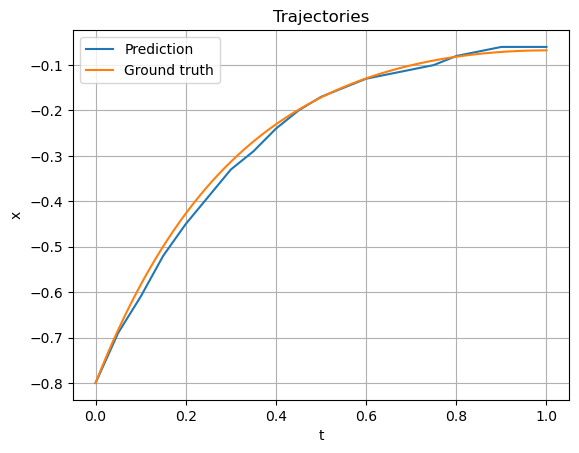

In [448]:
plot_trajectory(predicted_x=predicted_x, gt_x=gt_x)

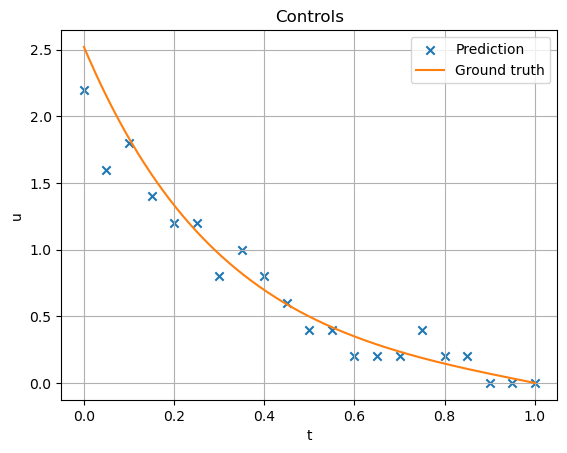

In [449]:
plot_control(predicted_u=predicted_u, gt_u=gt_u)

In [450]:
print("Cost for the predicted solution:", piece_wise_constant_u_cost(predicted_x, predicted_u, res=10000))
print("Optimal cost:", cost(gt_x, gt_u))

Cost for the predicted solution: 1.947155142857143
Optimal cost: 2.0164165334977184


Surprisingly, the agent performed better this time.

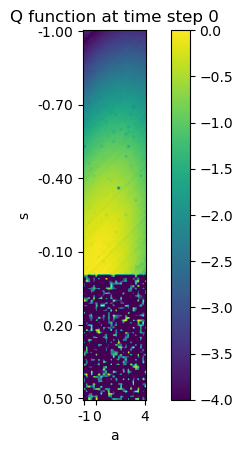

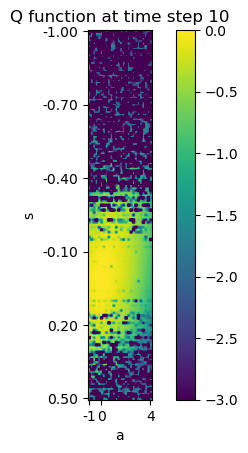

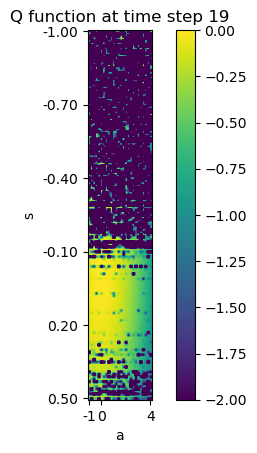

In [451]:
plot_Q(agent.Q, 0, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)), colorbar_limits=(-4, 0))
plot_Q(agent.Q, N//2, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)), colorbar_limits=(-3, 0))
plot_Q(agent.Q, N-1, state_zoom=(x_to_x_RL(-1), x_to_x_RL(0.5)), colorbar_limits=(-2, 0))

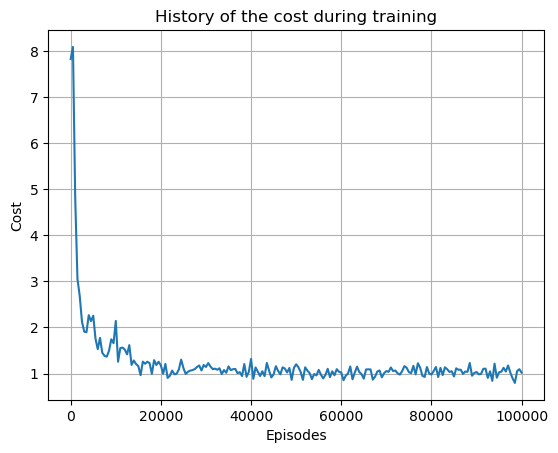

In [452]:
plot_loss_history(agent.training_history.cost, agent.training_history.evaluate_every, function_name="cost")

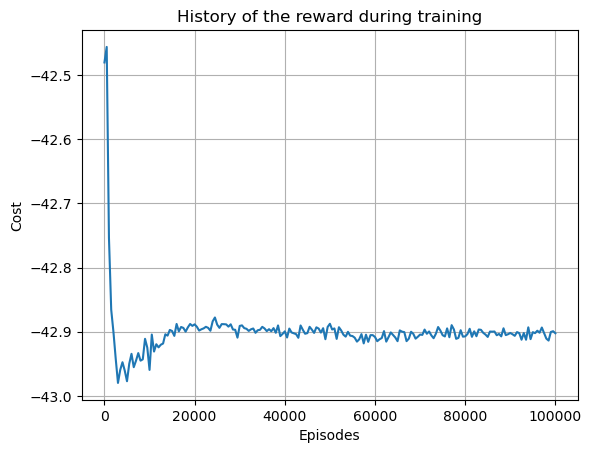

In [453]:
plot_loss_history(agent.training_history.reward, agent.training_history.evaluate_every, function_name="reward")

The agent converges much faster indeed!

For this problem, the best strategy seems to use a high learning rate to learn very quickly and still get good results.

## Deep Q-learning